# AdTracking Fraud Detection Challange

In [2]:
# Importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.cross_validation import train_test_split
import random

/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
# Importing data
dtypes = {'ip'            : 'uint32',
          'app'           : 'uint16',
          'device'        : 'uint16',
          'os'            : 'uint16',
          'channel'       : 'uint16',
          'is_attributed' : 'uint8',
          'click_id'      : 'uint32'
          } 

#n = 200000000
#s = 500000
#skip = sorted(random.sample(xrange(n), n-s))
train = pd.read_csv('/../../../Volumes/Data/train.csv',skiprows=range(1,129903891), nrows=500000, dtype=dtypes)
#test = pd.read_csv("test.csv", dtype=dtypes)
print(train.shape)
train.head()

In [3]:
# Check missing data
train.apply(lambda x: sum(x.isnull()))
# attributed_time is NaN when the app isn't downloaded after clicking on the ad
# https://www.kaggle.com/pranav84/xgboost-histogram-optimized-version/code
# ==> here they don't use 'attributed_time'. What do you think?

ip                      0
app                     0
device                  0
os                      0
channel                 0
click_time              0
attributed_time    498995
is_attributed           0
dtype: int64

In [4]:
# Unique values
train.apply(lambda x: len(x.unique()))

ip                 30191
app                  172
device               156
os                   137
channel              151
click_time           825
attributed_time      924
is_attributed          2
dtype: int64

In [5]:
train.dtypes

ip                 uint32
app                uint16
device             uint16
os                 uint16
channel            uint16
click_time         object
attributed_time    object
is_attributed       uint8
dtype: object

In [6]:
# Extract day, hour and day of the week
train['hour'] = pd.to_datetime(train.click_time).dt.hour.astype('uint8')
train['day']  = pd.to_datetime(train.click_time).dt.day.astype('uint8')
train['dow']  = pd.to_datetime(train.click_time).dt.dayofweek.astype('uint8')

In [7]:
# # of clicks for each ip-day-hour combination
gp = train[['ip','day','hour','channel']].groupby(by=['ip','day','hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'qty'})
train = train.merge(gp, on=['ip','day','hour'], how='left')
del gp

In [8]:
# # of clicks for each ip-app combination
gp = train[['ip','app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
train = train.merge(gp, on=['ip','app'], how='left')
del gp

In [9]:
# Count the number of clicks by ip
ip_count = train.groupby(['ip'])['channel'].count().reset_index()
ip_count.columns = ['ip', 'clicks_by_ip']
train = pd.merge(train, ip_count, on='ip', how='left', sort=False)
train['clicks_by_ip'] = train['clicks_by_ip'].astype('uint16')

In [10]:
# Delete columns we don't need
train.drop(['ip'], axis=1, inplace=True)
train.drop(['day'], axis=1, inplace=True)
train.drop(['click_time'], axis=1, inplace=True)
train.drop(['attributed_time'], axis=1, inplace=True)

#change features to 'uint16'
train['qty'] = train['qty'].astype('uint16')
train['ip_app_count'] = train['ip_app_count'].astype('uint16')

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 499999
Data columns (total 10 columns):
app              500000 non-null uint16
device           500000 non-null uint16
os               500000 non-null uint16
channel          500000 non-null uint16
is_attributed    500000 non-null uint8
hour             500000 non-null uint8
dow              500000 non-null uint8
qty              500000 non-null uint16
ip_app_count     500000 non-null uint16
clicks_by_ip     500000 non-null uint16
dtypes: uint16(7), uint8(3)
memory usage: 11.9 MB


In [11]:
train.head()
#print(train[train['is_attributed'] != 0])

,app,device,os,channel,is_attributed,hour,dow,qty,ip_app_count,clicks_by_ip
0,12,1,13,245,0,23,2,37,15,37
1,13,1,17,477,0,23,2,223,9,223
2,26,1,19,121,0,23,2,12,1,12
3,3,1,13,452,0,23,2,48,5,48
4,18,1,19,134,0,23,2,16,1,16


In [12]:
X = train.drop('is_attributed', axis=1)
#y = pd.DataFrame(data=train['is_attributed'])
y = train['is_attributed']


print(X.shape, y.shape)

((500000, 9), (500000,))


In [13]:
# Gradient Boosting Machines
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

y_pred = gbrt.predict(X_test)
cm_gbrt = confusion_matrix(y_test, y_pred)

print('accuracy on training set: %f' % gbrt.score(X_train, y_train))
print('accuracy on test set: %f' % gbrt.score(X_test, y_test))
print(cm_gbrt)


accuracy on training set: 0.998336
accuracy on test set: 0.998080
[[124677     45]
 [   195     83]]


([<matplotlib.axis.XTick at 0x1174b67d0>,
 <a list of 9 Text xticklabel objects>)

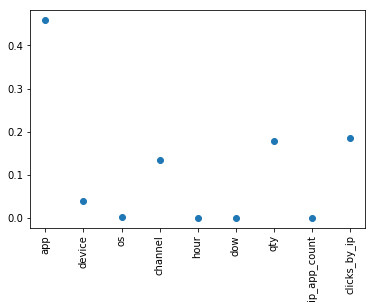

In [14]:
%matplotlib inline
plt.plot(gbrt.feature_importances_, 'o')
plt.xticks(range(X.shape[1]), X.columns.values, rotation=90)


In [35]:
# Light GBM
import lightgbm as lgb

d_train = lgb.Dataset(X_train, label=y_train)
#params = {}
#params['learning_rate'] = 0.003
#params['boosting_type'] = 'gbdt'
#params['objective'] = 'binary'
#params['metric'] = 'auc'
#params['sub_feature'] = 0.5
#params['num_leaves'] = 50
#params['min_data'] = 200
#params['max_depth'] = 50
#params['max_bin'] = 1000
#params['categorical_feature'] = '0, 1, 2, 3, 4, 5'
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 255,  
    'max_depth': 9,  
    'min_child_samples': 100,  
    'max_bin': 100,  
    'subsample': 0.7,  
    'subsample_freq': 1,  
    'colsample_bytree': 0.7,  
    'min_child_weight': 0,  
    'subsample_for_bin': 200000,  
    'min_split_gain': 0,  
    'reg_alpha': 0,  
    'reg_lambda': 0,  
   # 'nthread': 8,
    'verbose': 0,
    'is_unbalance': True
    #'scale_pos_weight':99 
    }
clf = lgb.train(params, d_train, 1000)

In [36]:


#Prediction
y_pred = clf.predict(X_test)
#convert into binary values
for i in range(0, 125000):
    if y_pred[i]>=.5:       # setting threshold to .5
        y_pred[i]=1
    else:  
        y_pred[i]=0


In [37]:
# classification report
from sklearn.metrics import classification_report
target_names = ['0', '1']
print(classification_report(y_test, y_pred, target_names=target_names))
#Confusion matrix
from sklearn.metrics import confusion_matrix

cm_clf = confusion_matrix(y_test, y_pred)
print(cm_clf)
#Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred,y_test)
print('test: %f' % accuracy)

             precision    recall  f1-score   support

          0       1.00      0.96      0.98    124722
          1       0.03      0.53      0.05       278

avg / total       1.00      0.96      0.98    125000

[[119744   4978]
 [   130    148]]
test: 0.959136


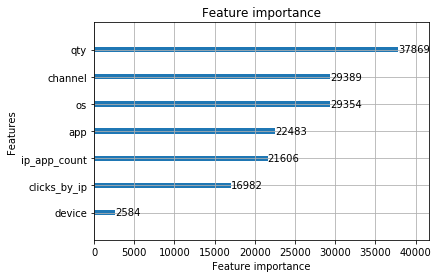

In [34]:
lgb.plot_importance(clf)